# Metropolis MCMC vs preconditioned Crank Nicolson

### preconditioned Crank-Nicolson
This notebook demonstrates the preconditioned Crank-Nicolson (pCN) algorithm, where proposals for a Markov Chain Monte Carlo (MCMC) sampler are generated by:

\begin{equation}
\theta' = \sqrt{1 - \beta^2}\theta^{(i)} + \beta \xi
\end{equation}
where $\beta$ is a tuning parameter and $\xi$ is a random draw from the prior. The pCN algorithm is non-symmetric and the acceptance ratio is simply:

\begin{equation}
\alpha = \frac{\mathcal{L}(\theta')}{\mathcal{L}(\theta^{(i)})}
\end{equation}
where $\mathcal{L}(\cdot)$ is the likelihood of a given parameter set. The example in this notebooks is taken from Cotter et al. (2013), which also introduces the pCN algortihm.

### Target Density
We draw samples $y_i$ from the true density $\rho \propto \mathcal{N}(-3, 1)\mathbb{I}(x \in (-\ell, +\ell)) + \mathcal{N}(3, 1)\mathbb{I}(x \in (-\ell, +\ell))$, where $\ell = 10$. We then fit a density function:

\begin{equation}
\rho(x) = \frac{\exp(u(x))}{\int_{-\ell}^{\ell} \exp(u(s)) \: ds}
\end{equation}
to the samples, placing a Gaussian Process prior $\mu_0$ on $u$. The likelihood function is then $\mathcal{L}(u) = -\sum_{i=1}^{d_y} \ln \rho(y_i)$. Please refer to Cotter et al. (2013) for more detail on the example.

### References
Cotter, S. L., Roberts, G. O., Stuart, A. M., & White, D. (2013). MCMC Methods for Functions: Modifying Old Algorithms to Make Them Faster. Statistical Science, 28(3), 424–446. https://doi.org/10.1214/13-STS421

In [1]:
# Import time for benchmarking
import time

# Get the essentials
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate

from scipy.interpolate import interp1d
from scipy.linalg import eigh
from scipy.spatial import distance_matrix

# Get the good stuff.
import pymc3 as pm

import theano
import theano.tensor as tt

#from RandomProcess import SquaredExponential

In [2]:
print('Theano version: {}'.format(theano.__version__))
print('PyMC3 version: {}'.format(pm.__version__))

Theano version: 1.0.5
PyMC3 version: 3.9.3


In [6]:
# Sample from a multi-modal normal distribution with mu=-3 and mu=3
def sample(n_draws):
    return np.concatenate((np.random.normal(loc=-3, scale=1, size=int(n_draws/2)), np.random.normal(loc=3, scale=1, size=int(n_draws/2))))

In [7]:
# Number of samples from the true distribution.
n_samples = 32

# Draw the samples.
samples = sample(n_samples)

# Number of midpoints in discretisation. Numerical integration points will be n_dim+1 for Romberg integration.
n_dim = 32

# Make the histrograms and get the bins
hist, x = np.histogram(samples, n_dim, [-10, 10])

# compute the midpoints.
midpoints = (x[1:] + x[:-1])/2; dx = x[1]-x[0]

# Compute the true distribution.
dist = stats.norm()
y = (dist.pdf(x+3) + dist.pdf(x-3))/2

# See if the true distribution is really a distribution.
np.testing.assert_almost_equal(actual=integrate.romb(y, dx), desired=1, decimal=3, err_msg='y is not a distribution')

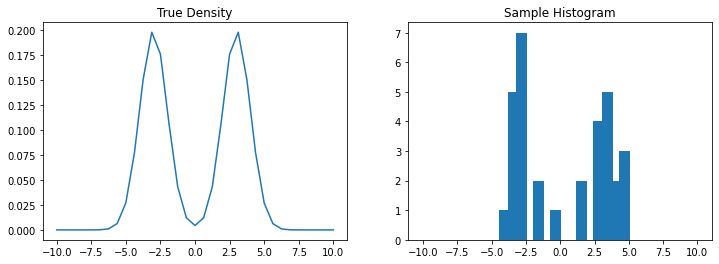

In [8]:
# Plot the density and the samples.
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].set_title('True Density')
axes[0].plot(x, y)
axes[1].set_title('Sample Histogram')
axes[1].bar(midpoints, hist)
plt.show()

In [9]:
class SquaredExponential:
    '''
    This class operationalises a Squared Exponential Gaussian Process,
    with a Karhunen-Loeve decomposition.
    '''
    
    def __init__(self, coords, mkl, lamb):
        """
        This class sets up a random process
        on a grid and generates
        a realisation of the process, given
        parameters or a random vector.
        """
        
        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        
        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb
        
        self.assemble_covariance_matrix()
        
    def assemble_covariance_matrix(self):
        
        # Create a snazzy distance-matrix for rapid
        # computation of the covariance matrix.
        dist = distance_matrix(self.coords,
                               self.coords)
        
        # Compute the covariance between all
        # points in the space.
        self.cov = np.exp(-0.5 * dist ** 2 /
                          self.lamb ** 2)
    
    def plot_covariance_matrix(self):
        """
        Plot the covariance matrix.
        """
        plt.figure(figsize=(10, 8))
        plt.imshow(self.cov, cmap='binary')
        plt.colorbar()
        plt.show()
    
    def compute_eigenpairs(self):
        """
        Find eigenvalues and eigenvectors using Arnoldi iteration.
        """
        eigvals, eigvecs = eigh(self.cov,
                                eigvals=(self.n_points - self.mkl,
                                         self.n_points - 1))
        
        # Flip the order from larger to smaller
        order = np.flip(np.argsort(eigvals))
        self.eigenvalues = eigvals[order]
        self.eigenvectors = eigvecs[:, order]
      
    def generate(self, parameters=None):
        """
        Generate a random field, see S. L. Cotter, et al.,
        MCMC Methods for Functions: Modifying
        Old Algorithms to Make Them Faster
        """
        
        if parameters is None:
            self.parameters = np.random.normal(size=self.mkl)
        else:
            self.parameters = np.array(parameters).flatten()
        
        self.random_field = np.linalg.multi_dot((self.eigenvectors, np.diag(np.sqrt(self.eigenvalues)), self.parameters))

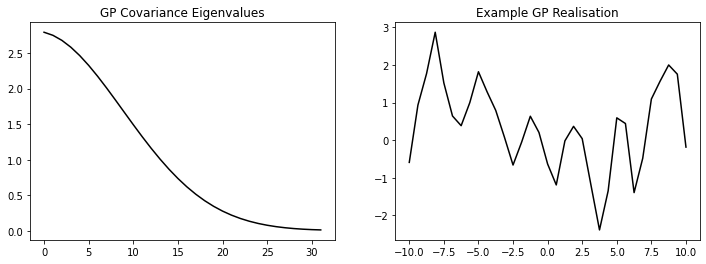

In [10]:
# Set the active number of dimensions in the KL decomposition.
mkl = 32

# Set the covariance length scale.
lamb = 0.7

# Set up the GP and compute the KL eigenpairs.
random_process = SquaredExponential(np.c_[x, np.zeros(len(x))], mkl, lamb)
random_process.compute_eigenpairs()
#random_process.plot_covariance_matrix()

# Plot the eigenvalues and an example realisation.
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].set_title('GP Covariance Eigenvalues')
axes[0].plot(random_process.eigenvalues, c='k')

random_process.generate()
axes[1].set_title('Example GP Realisation')
axes[1].plot(x, random_process.random_field, c='k')
plt.show()

In [11]:
# Number of draws from the distribution
ndraws = 10000

# Number of burn-in samples
nburn = 5000

# Number of independent chains
nchains = 4

# Set the prior covariance (mean is zero for pCN)
mu_prior = np.zeros(mkl)
cov_prior = np.eye(mkl)

# Set the scaling for the Random Walk and for pCN.
scaling_RW = 0.5
beta_pCN = 0.5

# Allow tuning for both algorithms to have optimal acceptance rate.
tune = True
tune_interval = 100

# Sampling seed
sampling_seed = 1234

In [12]:
class Phi(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, random_process, observations):

        # add the random process as a class attribute.
        self.random_process = random_process
        
        # Set the integration points.
        self.x = self.random_process.coords[:,0]
        self.dx = self.x[1] - self.x[0]
        
        # Set the observations.
        self.y = observations

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs  # this will contain my variables
        
        # Generate a realisation of the random process given the input parameters.
        self.random_process.generate(theta)
        
        # Create an interpolator for the random process.
        u = interp1d(self.x, self.random_process.random_field, kind='linear')
        
        # Get the densities of all the observations.
        rho_y = np.exp(u(self.y))/integrate.romb(np.exp(self.random_process.random_field), self.dx)
        
        # Compute the likelihood.
        phi = np.log(rho_y).sum()
        
        # Set the likelihood in the operator output.
        outputs[0][0] = np.array(phi) # output the log-likelihood

# Initialise the likelihood function
phi = Phi(random_process, samples)

In [13]:
with pm.Model() as model:
    
    # Set te prior distribution of parameters.
    theta = pm.MvNormal('theta', mu=mu_prior, cov=cov_prior, shape=mkl)
    
    # Set up the likelihood function.
    potential = pm.Potential('potential', phi(theta))
    
    # FInd the Maximum a Posteriori points (not used as starting point!)
    MAP = pm.find_MAP()
    
    # Get the MAP distribution.
    theta_MAP = MAP['theta']
    random_process.generate(theta_MAP)
    rho_MAP = np.exp(random_process.random_field)/integrate.romb(np.exp(random_process.random_field), dx)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 24 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.



Acceptance rate: 0.334775

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
theta[0]  -0.924  0.970  -2.759    0.757      0.067    0.047     211.0   
theta[1]   0.273  0.664  -1.035    1.444      0.033    0.023     410.0   
theta[2]   1.766  0.740   0.329    3.126      0.036    0.026     415.0   
theta[3]  -0.038  0.644  -1.211    1.208      0.030    0.021     454.0   
theta[4]   2.132  0.691   0.885    3.441      0.036    0.026     375.0   
theta[5]   0.521  0.671  -0.726    1.757      0.034    0.024     391.0   
theta[6]  -1.607  0.737  -3.033   -0.246      0.040    0.028     338.0   
theta[7]   0.392  0.689  -0.881    1.684      0.038    0.027     323.0   
theta[8]  -0.768  0.731  -2.183    0.534      0.039    0.028     348.0   
theta[9]   0.160  0.741  -1.218    1.581      0.042    0.030     310.0   
theta[10]  0.591  0.752  -0.779    2.051      0.037    0.026     421.0   
theta[11]  0.423  0.762  -1.093    1.811      0.041    0.029     339.0   
theta[12] 

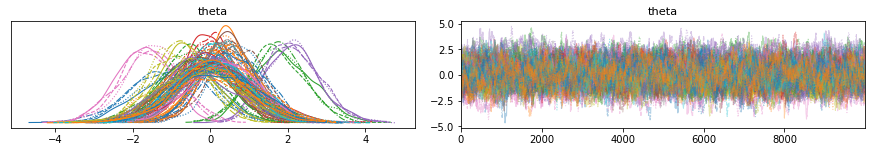

In [14]:
with model:
    
    # Initialise a Metropolis step method object
    step_metropolis = pm.Metropolis(scaling=scaling_RW, tune=tune, tune_interval=tune_interval)

    start = time.time()
    
    # Inference!
    # Metropolis
    trace_RW = pm.sample(draws=ndraws, step=step_metropolis,
                            chains=nchains, tune=nburn,
                            random_seed=sampling_seed)
    
    runtime_RW = time.time() - start
    performance_RW = np.array(pm.ess(trace_RW).to_array())/runtime_RW
    
    # Get the acceptance rate, plot a summary and the trace
    print('\nAcceptance rate: {}\n'.format(trace_RW.get_sampler_stats('accepted').mean()))    
    print(pm.stats.summary(trace_RW))
    pm.plots.traceplot(trace_RW)

/home/mikkel/venv/pymc3_mlda_pcn/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


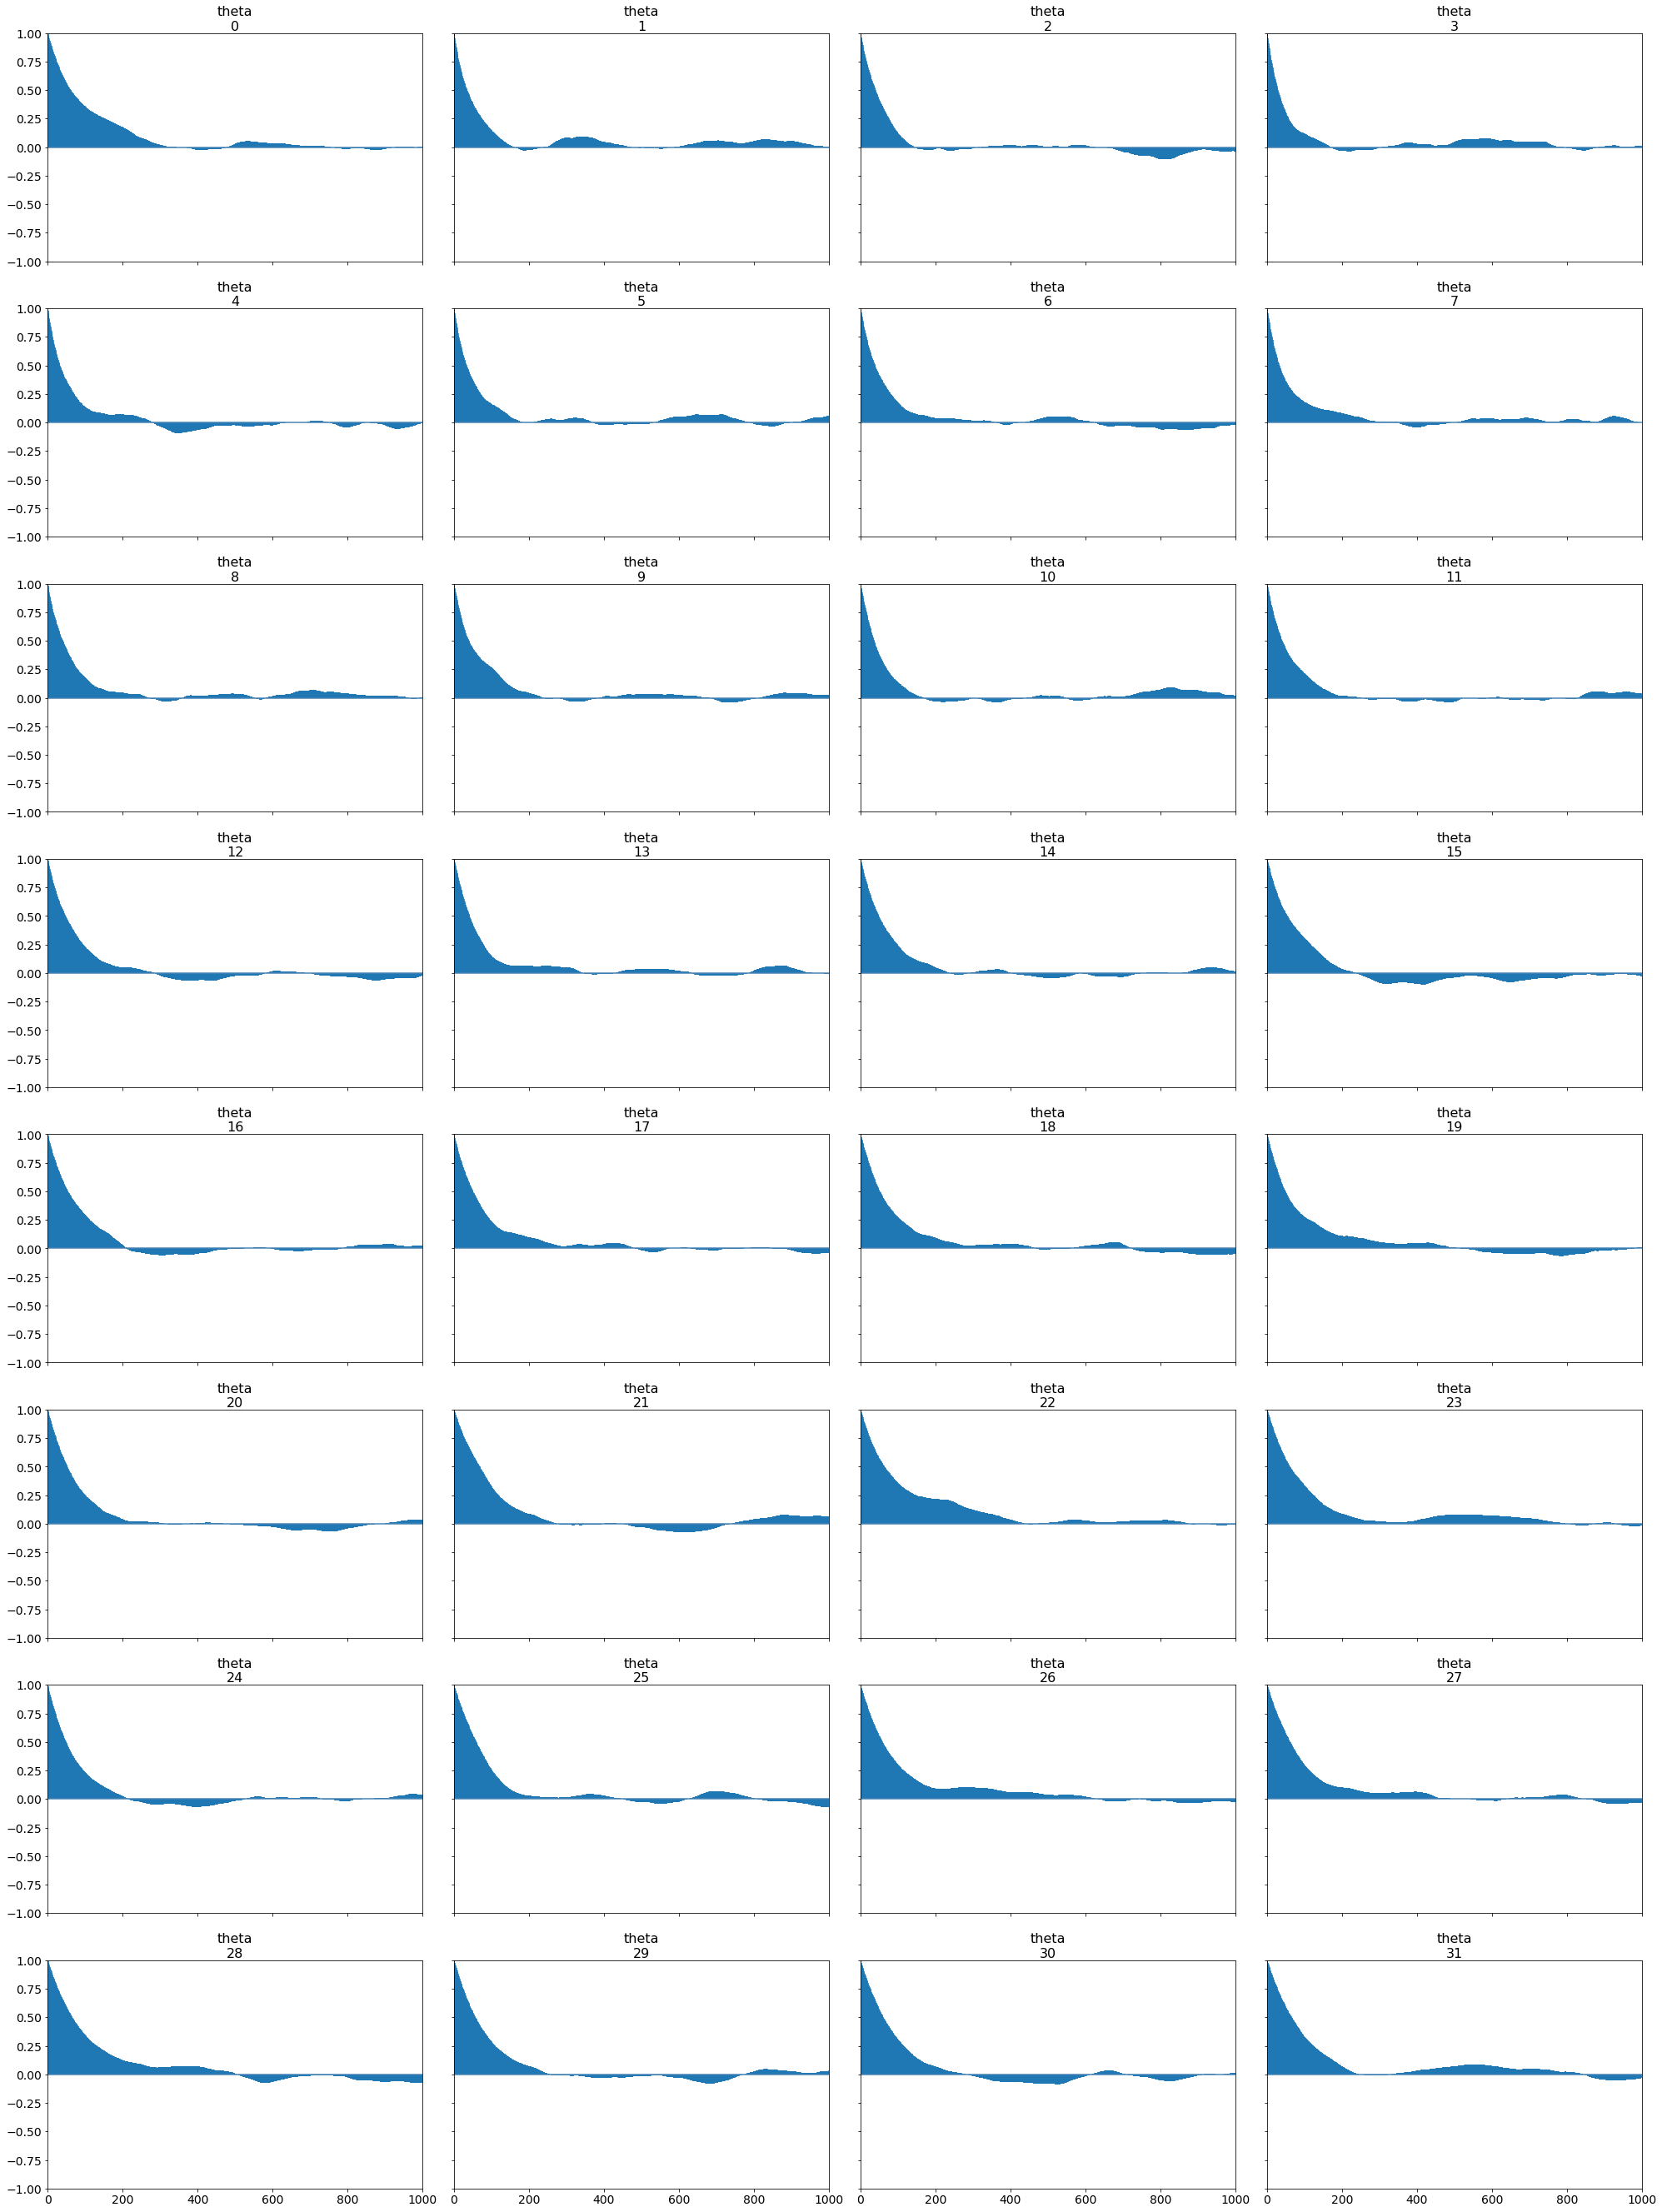

In [15]:
# Look at the autocorrelation of the parameters
pm.plots.autocorrplot(trace_RW, combined=True, max_lag=1000)
plt.show()

/home/mikkel/venv/pymc3_mlda_pcn/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


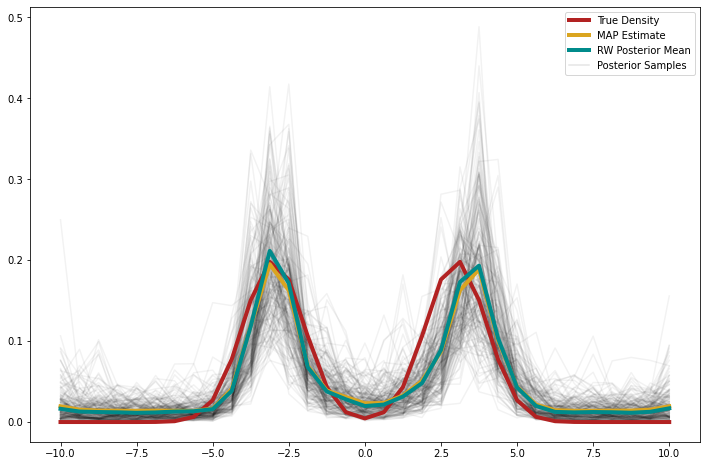

In [16]:
# Get the mean parameters and compute the mean rho.
theta_RW = trace_RW['theta'].mean(axis=0)
random_process.generate(theta_RW)
rho_RW = np.exp(random_process.random_field)/integrate.romb(np.exp(random_process.random_field), dx)

# Get the autocorrelation length.
tau = int(ndraws*nchains/np.array(pm.ess(trace_RW).to_array()).min())

# Plot true density, MAP estimate, mean of the Random Walk and some posterior samples.
plt.figure(figsize=(12,8))
for i in range(0, ndraws*nchains, tau):
    random_process.generate(trace_RW['theta'][i, :])
    rho_i = np.exp(random_process.random_field)/integrate.romb(np.exp(random_process.random_field), dx)
    plt.plot(x, rho_i, c='k', alpha=0.05)
plt.plot(x, y, c='firebrick', linewidth=4, label='True Density')
plt.plot(x, rho_MAP, c='goldenrod', linewidth=4, label='MAP Estimate')
plt.plot(x, rho_RW, c='darkcyan', linewidth=4, label='RW Posterior Mean')
plt.plot(0, 0, c='k', alpha=0.1, label='Posterior Samples')
plt.legend(loc=1)
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CrankNicolson: [theta]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 22 seconds.
The number of effective samples is smaller than 10% for some parameters.



Acceptance rate: 0.239725

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
theta[0]  -0.858  0.941  -2.630    0.848      0.044    0.031     459.0   
theta[1]   0.286  0.643  -0.900    1.476      0.022    0.016     845.0   
theta[2]   1.761  0.731   0.368    3.138      0.028    0.020     695.0   
theta[3]  -0.074  0.642  -1.270    1.154      0.023    0.017     750.0   
theta[4]   2.128  0.644   0.907    3.319      0.021    0.015     931.0   
theta[5]   0.549  0.692  -0.760    1.814      0.023    0.016     885.0   
theta[6]  -1.567  0.717  -2.966   -0.226      0.025    0.018     804.0   
theta[7]   0.370  0.709  -1.045    1.608      0.025    0.017     829.0   
theta[8]  -0.827  0.719  -2.153    0.509      0.026    0.019     736.0   
theta[9]   0.118  0.737  -1.288    1.463      0.028    0.020     697.0   
theta[10]  0.661  0.733  -0.666    2.052      0.027    0.019     753.0   
theta[11]  0.389  0.779  -1.014    1.902      0.031    0.022     636.0   
theta[12] 

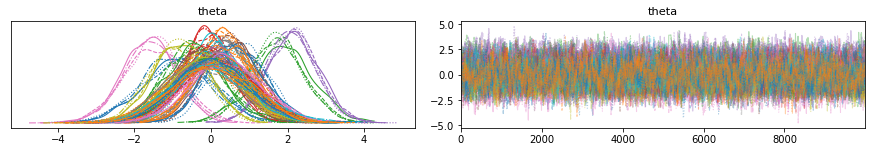

In [17]:
with model:
    
    # Initialise a CrankNicolson step method.
    step_pCN = pm.CrankNicolson(S=cov_prior, scaling=beta_pCN, tune=tune, tune_interval=tune_interval)

    start = time.time()
    # Inference!
    # Run sampling with the pCN stepper.
    trace_pCN = pm.sample(draws=ndraws, step=step_pCN,
                            chains=nchains, tune=nburn,
                            random_seed=sampling_seed)
    
    runtime_pCN = time.time() - start
    performance_pCN = np.array(pm.ess(trace_pCN).to_array())/runtime_pCN
    
    # Get the acceptance rate, plot a summary and the trace
    print('\nAcceptance rate: {}\n'.format(trace_pCN.get_sampler_stats('accepted').mean()))
    print(pm.stats.summary(trace_pCN))
    pm.plots.traceplot(trace_pCN)

/home/mikkel/venv/pymc3_mlda_pcn/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


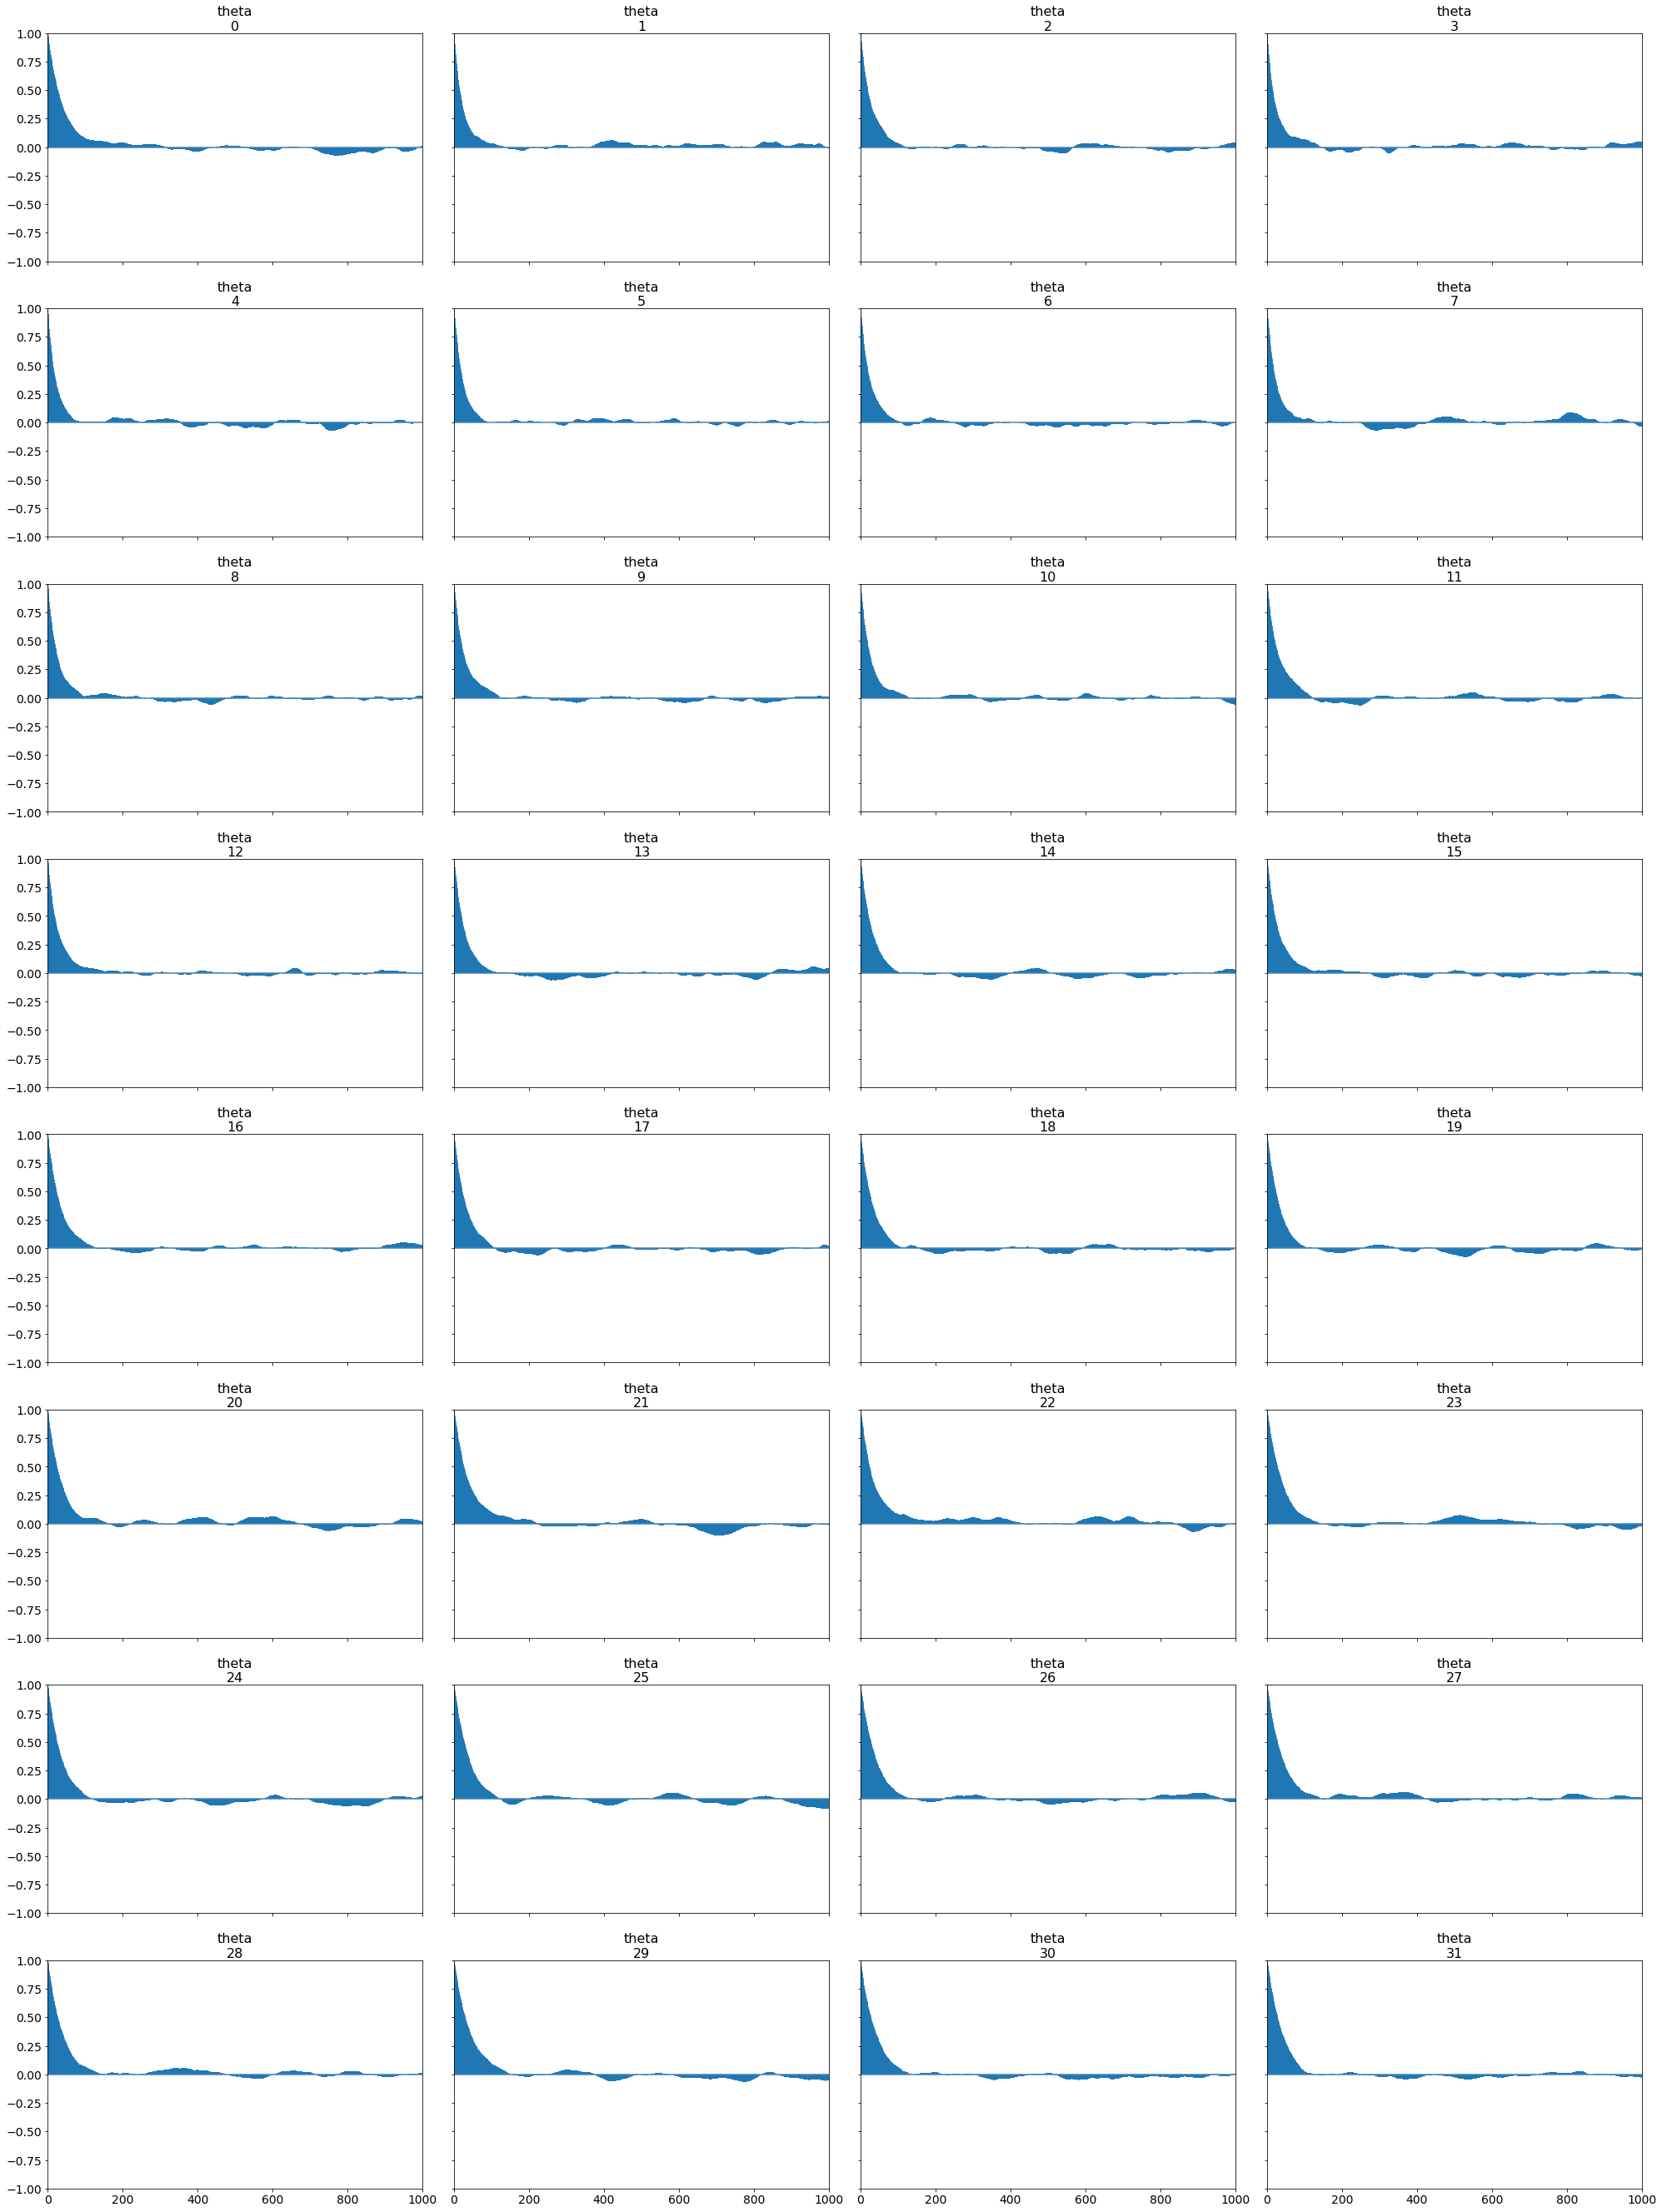

In [18]:
# Plot the autocorrelation.
pm.plots.autocorrplot(trace_pCN, combined=True, max_lag=1000)
plt.show()

/home/mikkel/venv/pymc3_mlda_pcn/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


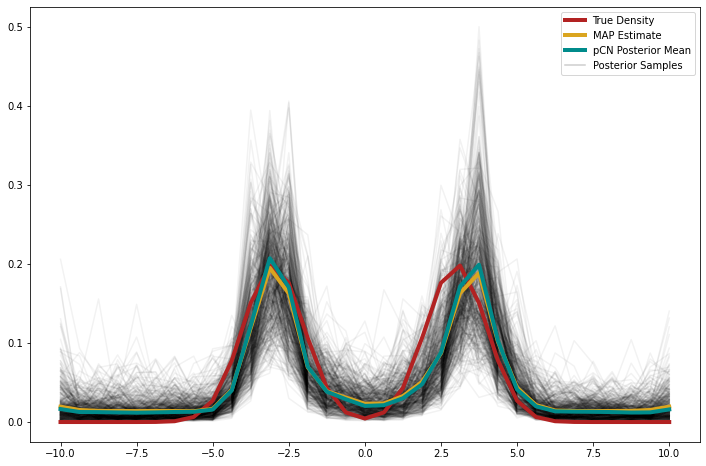

In [19]:
# Get the mean parameters and compute the mean rho.
theta_pCN = trace_pCN['theta'].mean(axis=0)
random_process.generate(theta_pCN)
rho_pCN = np.exp(random_process.random_field)/integrate.romb(np.exp(random_process.random_field), dx)

# Get the autocorrelation length.
tau = int(ndraws*nchains/np.array(pm.ess(trace_pCN).to_array()).min())

# Plot true density, MAP estimate, mean of the Random Walk and some posterior samples.
plt.figure(figsize=(12,8))
for i in range(0, ndraws*nchains, tau):
    random_process.generate(trace_pCN['theta'][i, :])
    rho_i = np.exp(random_process.random_field)/integrate.romb(np.exp(random_process.random_field), dx)
    plt.plot(x, rho_i, c='k', alpha=0.05)
plt.plot(x, y, c='firebrick', linewidth=4, label='True Density')
plt.plot(x, rho_MAP, c='goldenrod', linewidth=4, label='MAP Estimate')
plt.plot(x, rho_pCN, c='darkcyan', linewidth=4, label='pCN Posterior Mean')
plt.plot(0, 0, c='k', alpha=0.2, label='Posterior Samples')
plt.legend(loc=1)
plt.show()